# <div align="center"> Cyber-Physical Intrusion Detection System for UAVs</div>

### <div align="center">FSD311 - Machine Learning</div>
#### <div align="center">Colin HERVIOU-LABORDE & Mohamed REGAIEG</div>

# Table of Contents

1. [Introduction](#introduction)
2. [Data Acquisition](#data-acquisition)
   1. [Data Extraction](#data-extraction)
   2. [Data Loading](#data-loading)
3. [Data Exploration](#data-exploration)
4. [Feature Engineering](#feature-engineering)
5. [Machine Learning](#machine-learning)
   1. [PCA](#x)
   2. [SVM](#x)
   3. [Decision Tree](#x)
   4. [Random Forest](#x)
   5. [XGBoost](#x)
5. [Fine tuning](#x)
   1. [Random Forest](#x)
   2. [XGBoost](#x)
6. [Summary](#x)




<a id="introduction"></a>
# **Introduction**

Unmanned Aerial Vehicles (UAVs), commonly known as drones, are increasingly being deployed for applications such as surveillance, delivery, environmental monitoring, and disaster management. However, the growing reliance on UAVs also exposes them to significant **cybersecurity risks**, as malicious actors can exploit vulnerabilities in their communication and control systems. To address this challenge, **intrusion detection systems (IDSs)** leveraging machine learning have become an active area of research.

This project utilizes the **Cyber-Physical Dataset for UAVs Under Normal Operations and Cyberattacks**, developed by **Hassler, Mughal, and Ismail (2023)**. The dataset captures both **cyber and physical telemetry data** from UAVs under normal flight conditions and during four distinct types of cyberattacks:

1. **De-authentication Denial-of-Service (DoS) attack**
2. **Replay attack**
3. **False Data Injection (FDI) attack**
4. **Evil Twin attack**

The dataset is composed of two major components:

* **Cyber dataset** containing 37 features that describe network-level parameters and communication behavior.
* **Physical dataset** containing 16 features that represent UAV motion dynamics such as altitude, velocity, position, and orientation.

Each record in the dataset corresponds to either **benign (normal)** operation or one of the aforementioned **attack scenarios**, making it suitable for **binary (normal vs. malicious)** or **multi-class** classification tasks. The data were collected using a custom UAV testbed with real-time attack emulation and monitoring tools.


**Reference:**
Hassler, S. C., Mughal, U. A., & Ismail, M. (2023). *Cyber-Physical Intrusion Detection System for Unmanned Aerial Vehicles*. IEEE Transactions on Intelligent Transportation Systems.
Available via GitHub: [https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks](https://github.com/uamughal/UAVs-Dataset-Under-Normal-and-Cyberattacks)




### Imports

In [22]:
import os
import glob
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay


# **Datacquisition** 

## Data Extraction

In this step, we extract and clean the raw UAV dataset from the original combined CSV file. Each attack type and data modality (Cyber or Physical) is separated into individual CSV files based on predefined row ranges. During this process, we detect and apply proper headers, remove empty or irrelevant columns, and save the cleaned subsets to the output directory for further analysis

In [33]:
# === CONFIGURATION ===
csv_path = "Dataset_T-ITS.csv"     # your original file
output_dir = "Data"
os.makedirs(output_dir, exist_ok=True)

# === Definition of ranges (1-based, inclusive) ===
ranges = {
    "Benign":       {"Cyber": (1, 9426),     "Physical": (9427, 13717)},
    "DoS Attack":   {"Cyber": (13718, 25389),"Physical": (25390, 26363)},
    "Replay Attack":{"Cyber": (26364, 38370),"Physical": (38371, 39344)},
    "Evil Twin":    {"Cyber": (39345, 45028),"Physical": (45029, 50502)},
    "FDI":          {"Cyber": (50503, 53976),"Physical": (53977, 54784)}
}

# === READ WITHOUT HEADER ===
df_raw = pd.read_csv(csv_path, header=None)
n = len(df_raw)
print(f" File loaded ({n} rows)\n")

# === HEADER DETECTION FUNCTION BY KEYWORD ===
def is_header_line(row):
    return row.astype(str).str.contains("class", case=False, na=False).any()

# === EXTRACTION OF BLOCKS ACCORDING TO RANGES ===
for attack, parts in ranges.items():
    for part_name, (start, end) in parts.items():
        start_idx = max(0, start - 1)
        end_idx = min(n, end)
        sub_df = df_raw.iloc[start_idx:end_idx].copy()

        # Find the header line inside the block
        header_idx = sub_df.index[sub_df.apply(is_header_line, axis=1)]
        if len(header_idx) == 0:
            print(f" No header found in {attack} - {part_name} ({start}-{end}), skipped.")
            continue

        header_row = header_idx[0]
        header = sub_df.loc[header_row]

        # Remove lines before the header
        sub_df = sub_df.loc[header_row + 1:]
        sub_df.columns = header
        sub_df.reset_index(drop=True, inplace=True)

        # === 🔹 CLEAN EMPTY COLUMNS ===
        # Remove columns that are entirely empty
        sub_df = sub_df.dropna(axis=1, how='all')

        # Remove columns with empty or undefined names
        sub_df = sub_df.loc[:, [str(c).strip() not in ["", "Unnamed: 0", "Unnamed: 1", "nan"] for c in sub_df.columns]]

        # Remove columns where all values are NaN or just empty commas
        sub_df = sub_df.loc[:, sub_df.apply(lambda col: not all(str(x).strip() in ["", "nan"] for x in col), axis=0)]

        # Count number of valid features
        valid_features = [c for c in sub_df.columns if pd.notna(c) and str(c).strip() != ""]
        n_features = len(valid_features)

        # Save the cleaned block
        filename = f"{attack.replace(' ', '_')}_{part_name}.csv"
        path_out = os.path.join(output_dir, filename)
        sub_df.to_csv(path_out, index=False)

        # Final display
        print(f" {attack} ({part_name}): {len(sub_df)} rows, {n_features} features")

print("\n Done: all blocks have been extracted and cleaned.")


 File loaded (54784 rows)

 Benign (Cyber): 9425 rows, 38 features
 Benign (Physical): 4290 rows, 17 features
 DoS Attack (Cyber): 11671 rows, 38 features
 DoS Attack (Physical): 973 rows, 17 features
 Replay Attack (Cyber): 12006 rows, 38 features
 Replay Attack (Physical): 973 rows, 17 features
 Evil Twin (Cyber): 5683 rows, 35 features
 Evil Twin (Physical): 5473 rows, 22 features
 FDI (Cyber): 3473 rows, 35 features
 FDI (Physical): 807 rows, 32 features

 Done: all blocks have been extracted and cleaned.


**Comment:**
As observed, the *Evil Twin* and *FDI* attack datasets (for both physical and cyber domains) contain a different number of features compared to the other classes, and their feature names also vary. Upon reviewing the original GitHub repository, several users noted that these subsets likely originate from a different research study. To ensure homogeneity and consistency across the dataset, we decided to **exclude the Evil Twin and FDI attacks (both physical and cyber)** from our analysis.

## Data Loading

The merging process combines the physical and cyber datasets based on synchronized timestamps and matching class labels, ensuring a unified cyber-physical dataset suitable for integrated UAV system analysis. As a result, we will create three datasets — Physical, Cyber, and Cyber-Physical — each containing three classes: Benign, DoS Attack, and Replay Attack.

In [2]:
# =====================================================
#            UAVs Dataset Merge Utility
# =====================================================
# Combines:
#   1️ Physical data files
#   2️ Cyber data files
#   3️ Merges both into Cyber-Physical dataset
# =====================================================


# ---------------- CONFIGURATION ----------------
DATA_DIR = "Data"
OUTPUTS = {
    "physical": os.path.join(DATA_DIR, "Merged_Physical.csv"),
    "cyber": os.path.join(DATA_DIR, "Merged_Cyber.csv"),
    "cp": os.path.join(DATA_DIR, "Merged_CP.csv"),
}

PHYSICAL_FILES = [
    "Benign_Physical.csv",
    "DoS_Attack_Physical.csv",
    "Replay_Attack_Physical.csv",
]

CYBER_FILES = [
    "Benign_Cyber.csv",
    "DoS_Attack_Cyber.csv",
    "Replay_Attack_Cyber.csv",
]

# ---------------- UTILITIES ----------------
def check_files_exist(files):
    """Ensure all files exist before processing."""
    for f in files:
        if not os.path.exists(f):
            raise FileNotFoundError(f"❌ File not found: {f}")

def clean_csv(df):
    """Remove repeated headers and empty rows."""
    df = df[~df.iloc[:, 0].astype(str).str.contains("class|timestamp", case=False, na=False)]
    return df.dropna(how="all").reset_index(drop=True)

def merge_csv_files(file_list, output_path):
    """Read, clean, and vertically concatenate multiple CSVs."""
    check_files_exist(file_list)

    dfs = []
    for i, f in enumerate(file_list):
        df = pd.read_csv(f)
        df = clean_csv(df)
        if i > 0:
            df.columns = dfs[0].columns  # align column names
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_path, index=False)
    print(f"✅ Merged {len(file_list)} files -> {output_path}")
    print(f"   {len(merged_df)} rows, {len(merged_df.columns)} columns\n")
    return merged_df

def normalize_class(c):
    """Standardize class labels."""
    c = str(c).strip().lower()
    if "dos" in c:
        return "dos"
    elif "replay" in c:
        return "replay"
    elif "benign" in c:
        return "benign"
    else:
        return c

def merge_cyber_physical(df_phys, df_cyber, output_path):
    """Synchronize and merge physical and cyber datasets."""
    # Check timestamps
    if "timestamp_p" not in df_phys.columns or "timestamp_c" not in df_cyber.columns:
        raise KeyError("❌ Columns 'timestamp_p' or 'timestamp_c' are missing.")

    # Rename for alignment
    df_phys = df_phys.rename(columns={"timestamp_p": "timestamp"})
    df_cyber = df_cyber.rename(columns={"timestamp_c": "timestamp"})

    # Check 'class' column
    if "class" not in df_phys.columns or "class" not in df_cyber.columns:
        raise KeyError("❌ Both files must contain a 'class' column.")

    # Normalize classes
    df_phys["class"] = df_phys["class"].apply(normalize_class)
    df_cyber["class"] = df_cyber["class"].apply(normalize_class)

    # Keep only common classes
    common_classes = set(df_phys["class"]) & set(df_cyber["class"])
    df_phys = df_phys[df_phys["class"].isin(common_classes)]
    df_cyber = df_cyber[df_cyber["class"].isin(common_classes)]
    print(f" Common classes: {common_classes}")

    # Sort and merge
    df_phys = df_phys.sort_values("timestamp")
    df_cyber = df_cyber.sort_values("timestamp")

    df_merged = pd.merge_asof(
        df_phys,
        df_cyber,
        on="timestamp",
        by="class",
        direction="backward"
    ).dropna(how="all").reset_index(drop=True)

    # Move 'class' to the end
    if "class" in df_merged.columns:
        cols = [c for c in df_merged.columns if c != "class"] + ["class"]
        df_merged = df_merged[cols]

    df_merged.to_csv(output_path, index=False)
    print(f"✅ Cyber-Physical merged -> {output_path}")
    print(f"   {len(df_merged)} rows, {len(df_merged.columns)} columns\n")
    return df_merged

# ---------------- MAIN PIPELINE ----------------
def main():
    print(" Starting UAV Dataset Merge Pipeline\n")

    # 1️⃣ Merge Physical
    phys_paths = [os.path.join(DATA_DIR, f) for f in PHYSICAL_FILES]
    df_phys = merge_csv_files(phys_paths, OUTPUTS["physical"])

    # 2️⃣ Merge Cyber
    cyber_paths = [os.path.join(DATA_DIR, f) for f in CYBER_FILES]
    df_cyber = merge_csv_files(cyber_paths, OUTPUTS["cyber"])

    # 3️⃣ Merge Cyber + Physical
    df_phys = pd.read_csv(OUTPUTS["physical"])
    df_cyber = pd.read_csv(OUTPUTS["cyber"])
    merge_cyber_physical(df_phys, df_cyber, OUTPUTS["cp"])

    print(" All merges completed successfully.")

# ---------------- EXECUTION ----------------
if __name__ == "__main__":
    os.makedirs(DATA_DIR, exist_ok=True)
    main()


 Starting UAV Dataset Merge Pipeline

✅ Merged 3 files -> Data/Merged_Physical.csv
   6236 rows, 17 columns

✅ Merged 3 files -> Data/Merged_Cyber.csv
   33102 rows, 38 columns

 Common classes: {'benign', 'replay', 'dos'}
✅ Cyber-Physical merged -> Data/Merged_CP.csv
   6236 rows, 53 columns

 All merges completed successfully.


# **Data Exploration**

In [3]:
# === LOAD DATASETS ===
data_Cyber = pd.read_csv("Data/Merged_Cyber.csv")
data_Physical = pd.read_csv("Data/Merged_Physical.csv")
data_CP = pd.read_csv("Data/Merged_CP.csv")

In [4]:
data_Cyber.describe()

,timestamp_c,frame.number,frame.len,frame.protocols,wlan.duration,wlan.ra,wlan.ta,wlan.da,wlan.sa,wlan.bssid,...,tcp.window_size,tcp.options,udp.srcport,udp.dstport,udp.length,data.data,data.len,wlan.fc.type,wlan.fc.subtype,time_since_last_packet
count,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.0,...,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000,33102.000000
mean,29046.388032,2065.692798,69.630808,0.694943,207.394810,0.668026,0.640958,0.668026,0.640958,0.0,...,4219.012748,0.065676,1804.941061,1805.346052,31.526101,14.263187,29.557036,0.938070,10.616096,0.172855
std,8146.923076,1405.390936,77.320924,1.165000,126.983295,0.738791,0.624219,0.738791,0.624219,0.0,...,15913.420770,0.247718,3575.693206,3576.492991,67.583008,45.614997,64.103887,0.998096,2.156720,0.751734
min,16369.541640,35.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22958.560997,978.000000,26.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.001669
50%,27579.979005,1754.000000,26.000000,0.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.003374
75%,31003.931215,2934.000000,86.000000,2.000000,314.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,0.029358
max,54392.419030,9248.000000,334.000000,5.000000,320.000000,14.000000,2.000000,14.000000,2.000000,0.0,...,64240.000000,1.000000,8889.000000,8899.000000,282.000000,471.000000,182.000000,2.000000,12.000000,28.844855


In [5]:
data_Physical.describe()

,timestamp_p,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,barometer,flight_time,battery,mp_distance_x,mp_distance_y,mp_distance_z
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,34355.921552,71.034317,0.118185,-0.076171,0.192271,-0.512989,-0.162444,50.148974,66.794259,92.022611,19156.903464,38.872996,63.500481,-12.555164,-14.363374,66.654907
std,9531.890291,13.766460,1.325337,0.865337,1.674684,1.834707,6.449911,91.007201,2.697857,284.152564,2566.937591,19.816874,22.626003,47.354315,45.022914,63.223443
min,16385.315220,-10.000000,-10.000000,-9.000000,-2.000000,-42.000000,-75.000000,-179.000000,53.000000,10.000000,13529.000000,2.000000,20.000000,-200.000000,-200.000000,-200.000000
25%,27713.490240,70.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,66.000000,79.000000,19122.000000,22.000000,45.000000,-13.000000,-15.000000,80.000000
50%,34381.459430,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,19835.500000,38.000000,65.000000,-4.000000,-6.000000,82.000000
75%,43670.806755,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,68.000000,82.000000,21173.000000,54.000000,82.000000,4.000000,4.000000,84.000000
max,54385.241520,120.000000,5.000000,10.000000,31.000000,32.000000,168.000000,179.000000,74.000000,6553.000000,21356.000000,95.000000,100.000000,70.000000,55.000000,122.000000


In [6]:
data_CP.describe()

,timestamp,height,x_speed,y_speed,z_speed,pitch,roll,yaw,temperature,distance,...,tcp.window_size,tcp.options,udp.srcport,udp.dstport,udp.length,data.data,data.len,wlan.fc.type,wlan.fc.subtype,time_since_last_packet
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,...,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,34355.921552,71.034317,0.118185,-0.076171,0.192271,-0.512989,-0.162444,50.148974,66.794259,92.022611,...,4687.171264,0.072963,3771.738614,3772.580661,65.447883,24.782713,61.872514,1.735728,9.621552,0.090192
std,9531.890291,13.766460,1.325337,0.865337,1.674684,1.834707,6.449911,91.007201,2.697857,284.152564,...,16708.652742,0.260097,4393.596335,4394.576340,84.450064,49.466437,80.739127,0.677331,2.259609,0.350189
min,16385.315220,-10.000000,-10.000000,-9.000000,-2.000000,-42.000000,-75.000000,-179.000000,53.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009
25%,27713.490240,70.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,66.000000,79.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000,0.003048
50%,34381.459430,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,80.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000,0.019899
75%,43670.806755,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.000000,68.000000,82.000000,...,0.000000,0.000000,8889.000000,8890.000000,175.000000,40.000000,167.000000,2.000000,12.000000,0.050514
max,54385.241520,120.000000,5.000000,10.000000,31.000000,32.000000,168.000000,179.000000,74.000000,6553.000000,...,64240.000000,1.000000,8889.000000,8899.000000,282.000000,448.000000,179.000000,2.000000,12.000000,3.481675


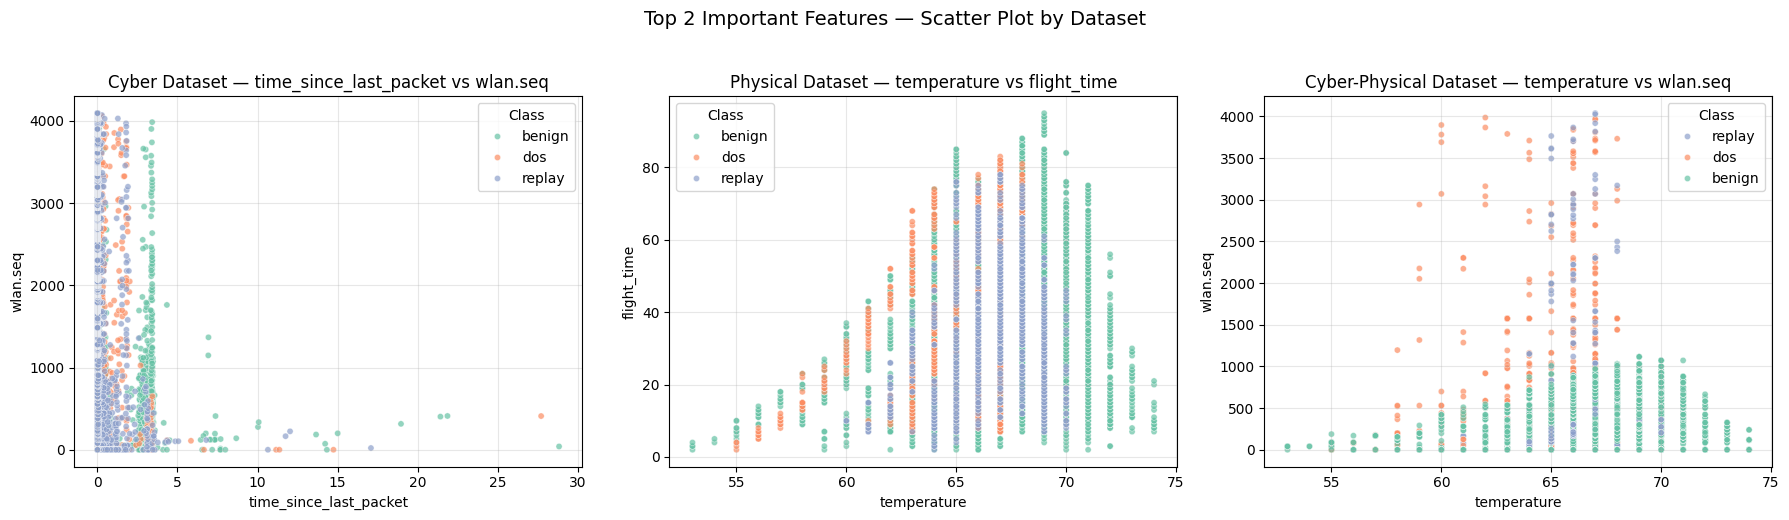

In [7]:
# =====================================================
#          UAVs Dataset — Exploratory Visualization
# =====================================================
# Plots the top 2 most important features for each dataset:
#   - Cyber:      time_since_last_packet vs wlan.seq
#   - Physical:   battery vs temperature
#   - Cyber-Phys: battery (physical) vs wlan.seq (cyber)
# =====================================================



# ---------------- CONFIGURATION ----------------
DATA_DIR = "Data"
DATASETS = {
    "Cyber": os.path.join(DATA_DIR, "Merged_Cyber.csv"),
    "Physical": os.path.join(DATA_DIR, "Merged_Physical.csv"),
    "Cyber-Physical": os.path.join(DATA_DIR, "Merged_CP.csv"),
}

TOP_FEATURES = {
    "Cyber": ["time_since_last_packet", "wlan.seq"],
    "Physical": ["temperature", "flight_time"],
    "Cyber-Physical": ["temperature", "wlan.seq"],  # physical + cyber
}

PALETTE = {"benign": "#66c2a5", "dos": "#fc8d62", "replay": "#8da0cb"}

# ---------------- LOAD AND PLOT ----------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, path) in zip(axes, DATASETS.items()):
    df = pd.read_csv(path)

    # Normalize class names (important!)
    df["class"] = (
        df["class"]
        .astype(str)
        .str.lower()
        .str.strip()
        .str.replace("attack", "", regex=False)
        .str.strip()
    )

    f1, f2 = TOP_FEATURES[name]
    if f1 not in df.columns or f2 not in df.columns:
        print(f"⚠️ Skipping {name}: missing features {f1}, {f2}")
        continue

    sns.scatterplot(
        data=df,
        x=f1,
        y=f2,
        hue="class",
        palette=PALETTE,
        s=20,
        alpha=0.7,
        ax=ax,
    )

    ax.set_title(f"{name} Dataset — {f1} vs {f2}")
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.grid(alpha=0.3)
    ax.legend(title="Class", loc="best")

plt.suptitle("Top 2 Important Features — Scatter Plot by Dataset", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()


The scatter plots show how the top two important features contribute to class separation across datasets. In the **Cyber dataset**, the classes (benign, DoS, replay) overlap heavily, indicating that `time_since_last_packet` and `wlan.seq` are not strongly discriminative and that nonlinear models like SVM with RBF or Random Forest are needed. In the **Physical dataset**, `temperature` and `flight_time` exhibit clearer trends, with distinct regions for each class, suggesting higher feature relevance. Finally, in the **Cyber-Physical dataset**, `temperature` and `wlan.seq` reveal partial clustering patterns that capture mixed physical and network behaviors, highlighting the complementarity of features from both domains.


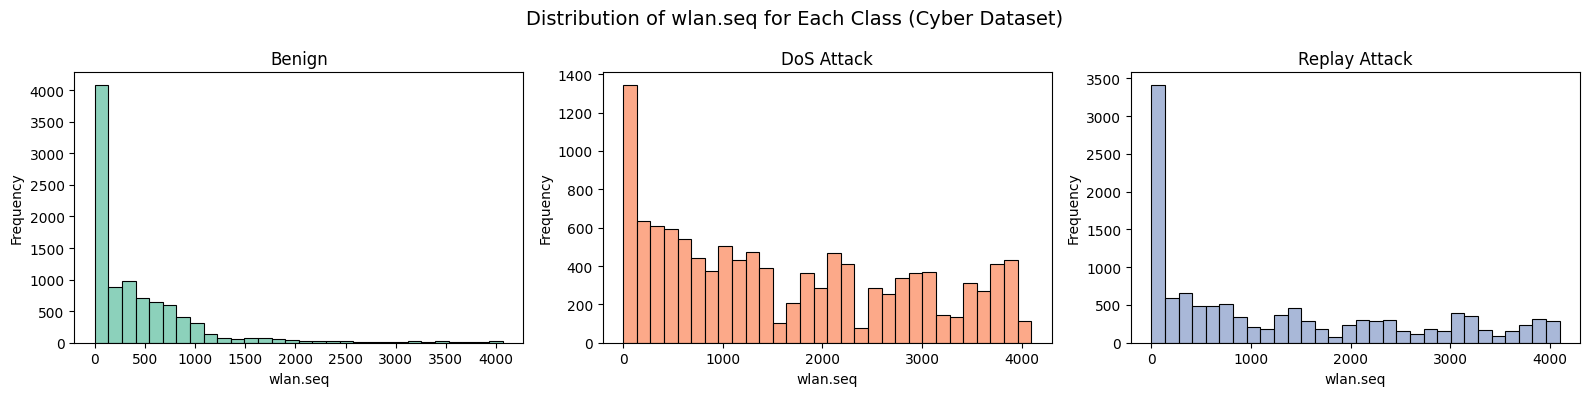

In [8]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of wlan.seq for Each Class (Cyber Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"] == "benign"]["wlan.seq"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("wlan.seq")
axes[0].set_ylabel("Frequency")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"].str.lower().str.contains("dos")]["wlan.seq"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("wlan.seq")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Cyber[data_Cyber["class"].str.lower().str.contains("replay")]["wlan.seq"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("wlan.seq")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The distributions show clear behavioral differences between classes. **Benign** traffic is concentrated at low `wlan.seq` values, reflecting stable communication. **DoS attacks** have a wider, irregular spread, indicating disrupted packet sequencing, while **Replay attacks** show repeated peaks from reused packets. This suggests `wlan.seq` helps distinguish normal from attack traffic.


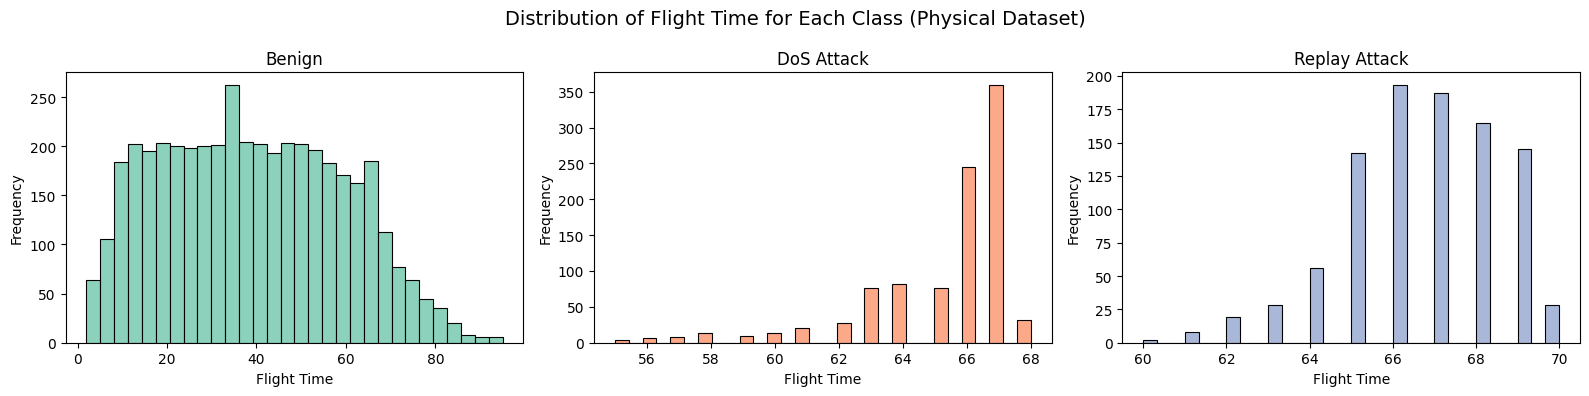

In [9]:
# === Create Subplots ===
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
fig.suptitle("Distribution of Flight Time for Each Class (Physical Dataset)", fontsize=14)

# === Histogram for Benign ===
sns.histplot(
    data=data_Physical[data_Physical["class"] == "benign"]["flight_time"],
    bins=30,
    ax=axes[0],
    kde=False,
    color="#66c2a5"
)
axes[0].set_title("Benign")
axes[0].set_xlabel("Flight Time")
axes[0].set_ylabel("Frequency")

# === Histogram for DoS Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("dos")]["temperature"],
    bins=30,
    ax=axes[1],
    kde=False,
    color="#fc8d62"
)
axes[1].set_title("DoS Attack")
axes[1].set_xlabel("Flight Time")
axes[1].set_ylabel("Frequency")

# === Histogram for Replay Attack ===
sns.histplot(
    data=data_Physical[data_Physical["class"].str.lower().str.contains("replay")]["temperature"],
    bins=30,
    ax=axes[2],
    kde=False,
    color="#8da0cb"
)
axes[2].set_title("Replay Attack")
axes[2].set_xlabel("Flight Time")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


The histograms show clear distinctions in **flight time** patterns across classes. **Benign** data is widely distributed, representing normal variations during regular UAV operations. In contrast, **DoS** and **Replay** attacks are concentrated within a narrow range around 65–68 seconds, indicating abnormal and repetitive behavior. This separation suggests that **flight time** is a strong discriminative feature in the Physical dataset for detecting attack scenarios.


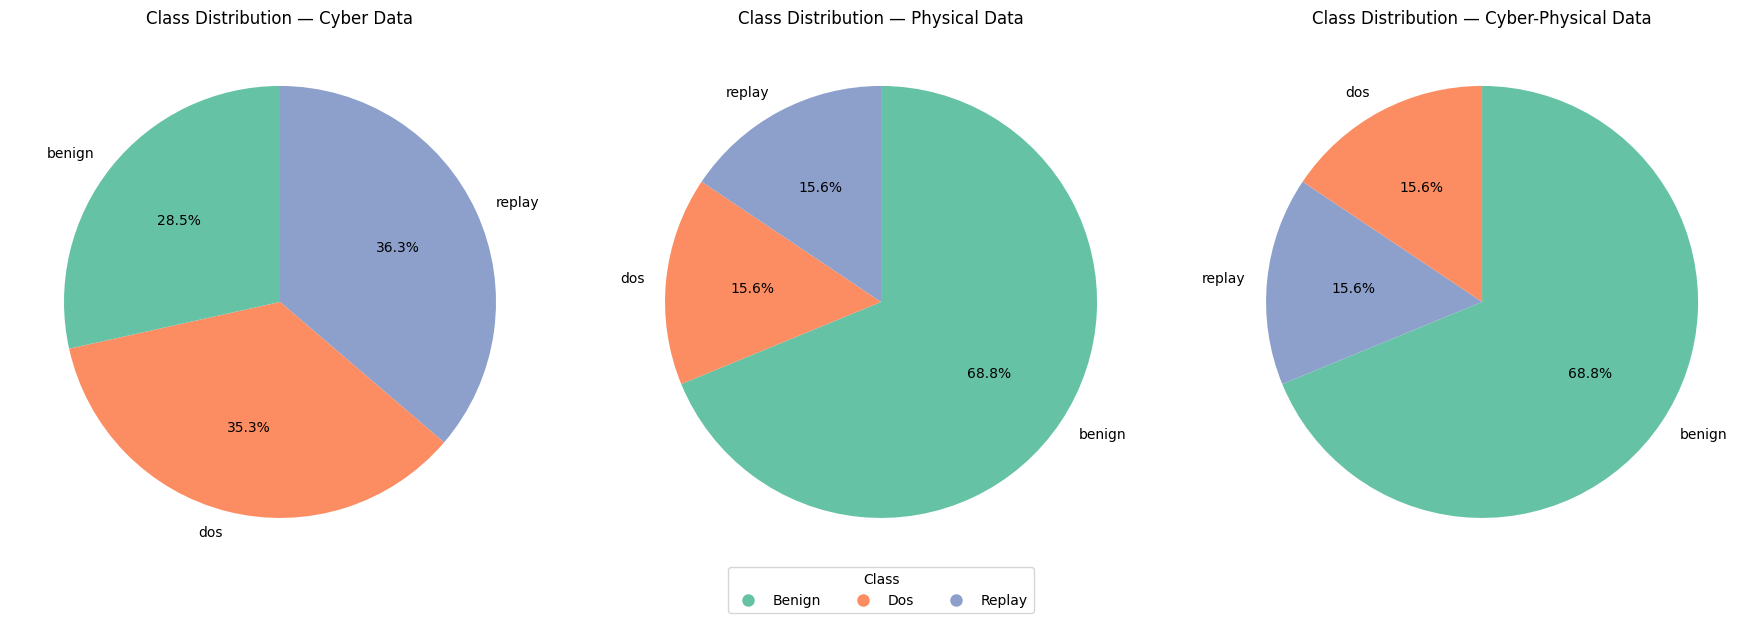

In [10]:
# === COLUMN VERIFICATION ===
for name, df in [("Cyber", data_Cyber), ("Physical", data_Physical), ("Cyber-Physical", data_CP)]:
    if "class" not in df.columns:
        raise KeyError(f"❌ The 'class' column is missing in {name}")

# === NORMALIZE CLASS LABELS ===
def normalize_labels(y):
    """Standardize class names for consistent plotting."""
    return (
        y.astype(str)
         .str.lower()
         .replace(r"\s+", "", regex=True)
         .replace({
             "dosattack": "dos",
             "dos_attack": "dos",
             "dos": "dos",
             "attackdos": "dos",
             "replay": "replay",
             "replayattack": "replay",
             "replay_attack": "replay",
             "attackreplay": "replay",
             "benign": "benign"
         })
    )

data_Cyber["class"] = normalize_labels(data_Cyber["class"])
data_Physical["class"] = normalize_labels(data_Physical["class"])
data_CP["class"] = normalize_labels(data_CP["class"])

# === CLASS COUNTS ===
class_counts_cyber = data_Cyber["class"].value_counts()
class_counts_physical = data_Physical["class"].value_counts()
class_counts_cp = data_CP["class"].value_counts()

# === FIXED COLOR MAP (same order for all) ===
class_colors = {
    "benign": "#66c2a5",   # greenish
    "dos": "#fc8d62",      # orange
    "replay": "#8da0cb"    # bluish
}

# === Function to get colors in class order ===
def get_colors(labels):
    return [class_colors.get(lbl, "#cccccc") for lbl in labels]

# === CREATE SUBPLOTS (1 row, 3 columns) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Pie chart: Cyber ---
axes[0].pie(
    class_counts_cyber,
    labels=class_counts_cyber.index,
    colors=get_colors(class_counts_cyber.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[0].set_title("Class Distribution — Cyber Data")

# --- Pie chart: Physical ---
axes[1].pie(
    class_counts_physical,
    labels=class_counts_physical.index,
    colors=get_colors(class_counts_physical.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[1].set_title("Class Distribution — Physical Data")

# --- Pie chart: Cyber-Physical ---
axes[2].pie(
    class_counts_cp,
    labels=class_counts_cp.index,
    colors=get_colors(class_counts_cp.index),
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
axes[2].set_title("Class Distribution — Cyber-Physical Data")

# === GLOBAL LEGEND ===
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cls.capitalize(),
               markerfacecolor=color, markersize=10)
    for cls, color in class_colors.items()
]
fig.legend(handles=handles, loc='lower center', ncol=3, title="Class")

# === ADJUSTMENTS ===
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


The pie charts show the class distribution across the Cyber, Physical, and Cyber-Physical datasets. The **Physical** and **Cyber-Physical** datasets share an identical distribution — with around 68% benign and 15.6% for each attack type — which is expected since the Cyber-Physical data was constructed through timestamp-based merging of the physical and cyber data (`pd.merge_asof` with the same class alignment). In contrast, the **Cyber** dataset is more balanced across classes, with higher proportions of DoS and Replay attacks. This imbalance difference is important, as it can affect model training and classifier behavior — models trained on more imbalanced datasets (like Physical and Cyber-Physical) may become biased toward the dominant benign class, while the Cyber dataset encourages more even decision boundaries.

# **Feature Engineering**

In this step, we applied a standardized preprocessing pipeline across all UAV datasets. Irrelevant or redundant columns (such as timestamps and sensor identifiers) were removed to reduce noise, and class labels were numerically encoded to ensure consistent representation of benign and attack types. Finally, Min–Max scaling was applied to all features, rescaling them between 0 and 1 to achieve uniform feature distributions and prevent scale-related bias during model training.

In [12]:
# === CONFIGURATION ===
input_dir = "Data"
files = {
    "Physical": f"{input_dir}/Merged_Physical.csv",
    "Cyber": f"{input_dir}/Merged_Cyber.csv",
    "CyberPhysical": f"{input_dir}/Merged_CP.csv"
}

# === FUNCTION TO LABEL ENCODE CLASS LABELS ===
def encode_class_labels(y):
    """
    Encode class labels numerically:
    - benign -> 0
    - replay -> 1
    - dos / dos_attack -> 2
    """
    y = y.astype(str).str.lower().str.replace(r"\s+", "", regex=True)
    return (
        y.replace({
            "benign": 0,
            "replay": 1,
            "dos": 2,
            "dosattack": 2,
        })
    ).astype(int)

# === COLUMNS TO DROP PER DATASET TYPE ===
drop_map = {
    "Physical": ['class', 'timestamp_p', 'barometer'],
    "Cyber": ['class', 'timestamp_c', 'frame.number'],
    "CyberPhysical": ['class', 'timestamp', 'frame.number', 'barometer']
}

# === PROCESSING PIPELINE ===
processed_data = {}

for name, path in files.items():
    df = pd.read_csv(path)

    # Drop irrelevant columns safely
    X = df.drop(columns=[c for c in drop_map[name] if c in df.columns], errors='ignore')

    # Encode class labels
    y = encode_class_labels(df['class'])

    # Shuffle to remove time dependence
    X, y = shuffle(X, y, random_state=42)

    # Min-Max scaling only
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    processed_data[name] = {
        "X_scaled": X_scaled,
        "y": y,
        "scaler": scaler
    }

# === EXTRACT VARIABLES FOR MODELING (only scaled data) ===
X_physical_scaled, y_physical = processed_data["Physical"]["X_scaled"], processed_data["Physical"]["y"]
X_cyber_scaled, y_cyber = processed_data["Cyber"]["X_scaled"], processed_data["Cyber"]["y"]
X_cp_scaled, y_cp = processed_data["CyberPhysical"]["X_scaled"], processed_data["CyberPhysical"]["y"]

# === FINAL OUTPUT ===
print("Scaled data ready for modeling: Physical, Cyber, and Cyber-Physical")


Scaled data ready for modeling: Physical, Cyber, and Cyber-Physical


/tmp/ipykernel_2794/665789864.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({
/tmp/ipykernel_2794/665789864.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({
/tmp/ipykernel_2794/665789864.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace({


### Principal Component Analysis

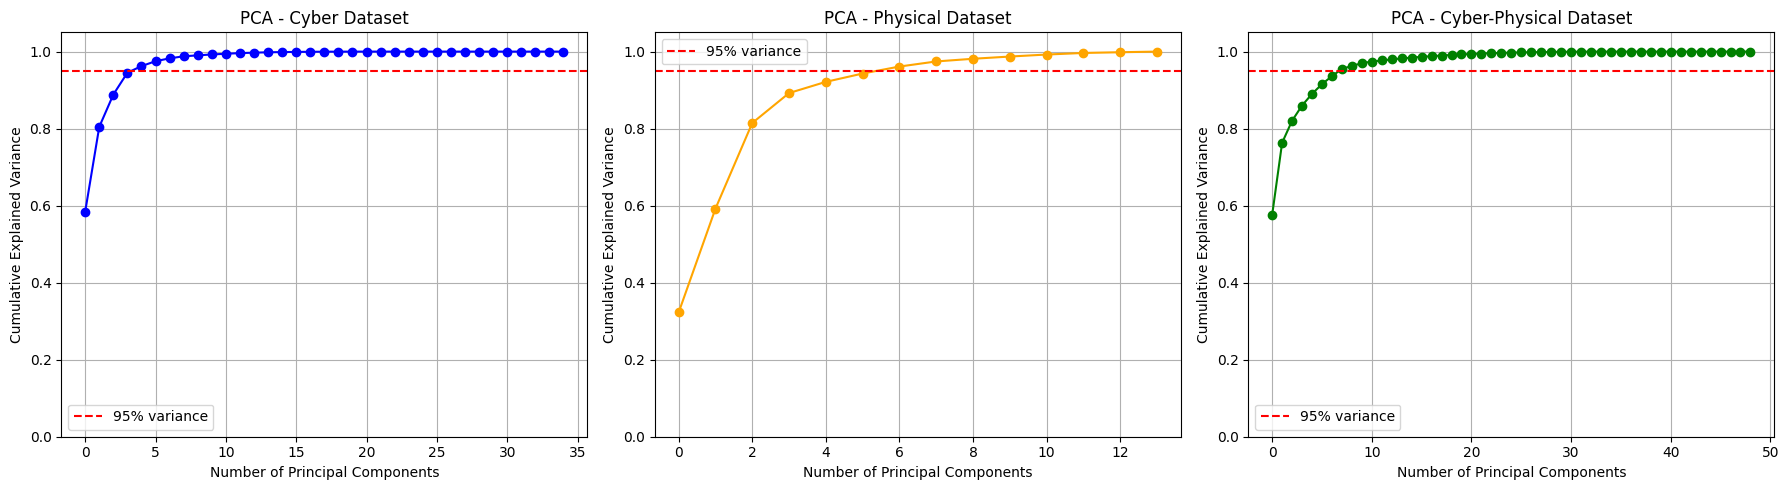

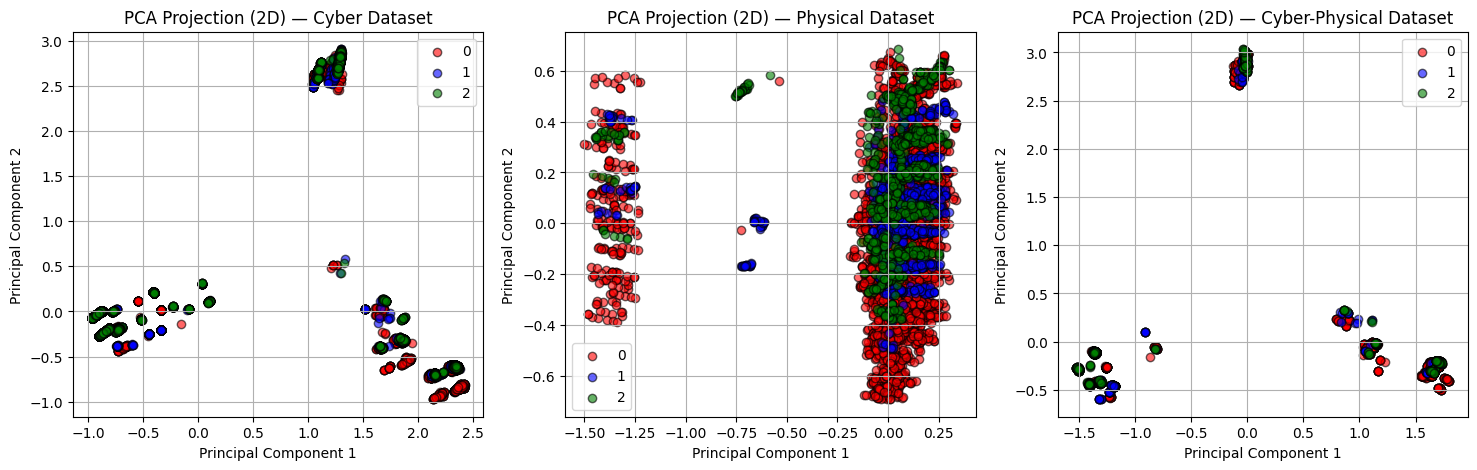


===== SUMMARY OF 2D PCA =====
Cyber                | PC1 explained variance: 58.45% | PC2 explained variance: 22.00% | Total explained variance (2D): 80.45%
Physical             | PC1 explained variance: 32.27% | PC2 explained variance: 26.95% | Total explained variance (2D): 59.22%
Cyber-Physical       | PC1 explained variance: 57.56% | PC1 explained variance: 18.75% | Total explained variance (2D): 76.32%


In [38]:
# === PCA FIT ===
pca_cyber = PCA().fit(X_cyber_scaled)
pca_physical = PCA().fit(X_physical_scaled)
pca_cp = PCA().fit(X_cp_scaled)

# === Cumulative Explained Variance ===
var_cum_cyber = np.cumsum(pca_cyber.explained_variance_ratio_)
var_cum_physical = np.cumsum(pca_physical.explained_variance_ratio_)
var_cum_cp = np.cumsum(pca_cp.explained_variance_ratio_)

# === Plot cumulative variance (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- Plot 1: Cyber Dataset ----
plt.subplot(1, 3, 1)
plt.plot(var_cum_cyber, marker='o', color='blue')
plt.title("PCA - Cyber Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 2: Physical Dataset ----
plt.subplot(1, 3, 2)
plt.plot(var_cum_physical, marker='o', color='orange')
plt.title("PCA - Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

# ---- Plot 3: Cyber-Physical Dataset ----
plt.subplot(1, 3, 3)
plt.plot(var_cum_cp, marker='o', color='green')
plt.title("PCA - Cyber-Physical Dataset")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

# === PCA with 2 components ===
pca2_cyber = PCA(n_components=2)
X_cyber_pca2 = pca2_cyber.fit_transform(X_cyber_scaled)
pca2_cyber_results = pca2_cyber.explained_variance_ratio_

pca2_physical = PCA(n_components=2)
X_physical_pca2 = pca2_physical.fit_transform(X_physical_scaled)
pca2_physical_results = pca2_physical.explained_variance_ratio_

pca2_cp = PCA(n_components=2)
X_cp_pca2 = pca2_cp.fit_transform(X_cp_scaled)
pca2_cp_results = pca2_cp.explained_variance_ratio_

# === Define classes and colors ===
colors = ['r', 'b', 'g', 'purple', 'orange']

classes_cyber = np.unique(y_cyber)
classes_physical = np.unique(y_physical)
classes_cp = np.unique(y_cp)

# === 2D PCA Visualization (3 side-by-side graphs) ===
plt.figure(figsize=(18, 5))

# ---- PCA Cyber ----
plt.subplot(1, 3, 1)
for i, cls in enumerate(classes_cyber):
    plt.scatter(
        X_cyber_pca2[y_cyber == cls, 0],
        X_cyber_pca2[y_cyber == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Physical ----
plt.subplot(1, 3, 2)
for i, cls in enumerate(classes_physical):
    plt.scatter(
        X_physical_pca2[y_physical == cls, 0],
        X_physical_pca2[y_physical == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)

# ---- PCA Cyber-Physical ----
plt.subplot(1, 3, 3)
for i, cls in enumerate(classes_cp):
    plt.scatter(
        X_cp_pca2[y_cp == cls, 0],
        X_cp_pca2[y_cp == cls, 1],
        c=colors[i % len(colors)],
        label=cls,
        alpha=0.6,
        edgecolors='k'
    )
plt.title("PCA Projection (2D) — Cyber-Physical Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# === Summary 2D PCA ===
print("\n===== SUMMARY OF 2D PCA =====")
print(f"{"Cyber ":20s} | PC1 explained variance: {pca2_cyber_results[0]*100:.2f}% | "
    f"PC2 explained variance: {pca2_cyber_results[1]*100:.2f}% | Total explained variance (2D): {pca2_cyber_results.sum()*100:.2f}%")
print(f"{"Physical ":20s} | PC1 explained variance: {pca2_physical_results[0]*100:.2f}% | "
    f"PC2 explained variance: {pca2_physical_results[1]*100:.2f}% | Total explained variance (2D): {pca2_physical_results.sum()*100:.2f}%")
print(f"{"Cyber-Physical ":20s} | PC1 explained variance: {pca2_cp_results[0]*100:.2f}% | "
    f"PC1 explained variance: {pca2_cp_results[1]*100:.2f}% | Total explained variance (2D): {pca2_cp_results.sum()*100:.2f}%")



The PCA results show that a small number of principal components capture over 95% of the data variance, meaning we can reduce dimensionality while preserving most information—useful for SVM modeling. However, the 2D PCA projections indicate that the classes (benign, replay, DoS) are not linearly separable, as clusters overlap significantly. This confirms that a **linear SVM** would not perform well, and thus applying the **kernel trick (e.g., RBF kernel)** is necessary to handle the nonlinear class boundaries effectively.


# **Machine Learning Models - Training**

## Support Vector Machine

In [45]:
# ===  RBF parameters ===
C = 10
gamma = 10

# === Store results ===
results = {}

# === Loop through datasets ===
for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        n_comp = 4
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        n_comp = 5
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        n_comp = 8

    # --- PCA dimensionality reduction ---
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X_scaled)

    # --- Train/test split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- SVM with RBF kernel ---
    svm_rbf = SVC(kernel='rbf', C=C, gamma=gamma)

    # --- Training ---
    training_start = time.perf_counter()
    svm_rbf.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = svm_rbf.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Evaluation ---
    acc_svm = accuracy_score(y_test, preds) * 100
    svm_train_time = training_end - training_start
    svm_prediction_time = prediction_end - prediction_start
    results[dataset] = {
        "accuracy": acc_svm,
        "train_time": svm_train_time,
        "pred_time": svm_prediction_time
    }

# === Summary ===
print("\n===== SUMMARY OF SVM (RBF) RESULTS =====")
for ds, res in results.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")



===== SUMMARY OF SVM (RBF) RESULTS =====
Cyber           | Accuracy: 65.27% | Train: 28.446s | Predict: 6.48018s
Physical        | Accuracy: 80.05% | Train: 0.612s | Predict: 0.18118s
Cyber_physical  | Accuracy: 89.03% | Train: 0.627s | Predict: 0.13153s


The SVM (RBF) achieved **65.27%** accuracy on the Cyber dataset, reflecting the high complexity of network features. Performance improved on the **Physical dataset (80.05%)**, where sensor data offers clearer class separation. The best result came from the **Cyber-Physical dataset (89.03%)**, showing that combining both domains enhances detection accuracy. Training was also faster on the Physical and Cyber-Physical data, indicating more efficient learning from cleaner, lower-dimensional features.


## Decision Tree


===== SUMMARY OF DECISION TREE RESULTS =====
Cyber           | Accuracy: 71.02% | Train: 0.222s | Predict: 0.00245s
Physical        | Accuracy: 97.05% | Train: 0.016s | Predict: 0.00043s
Cyber_physical  | Accuracy: 97.95% | Train: 0.042s | Predict: 0.00052s


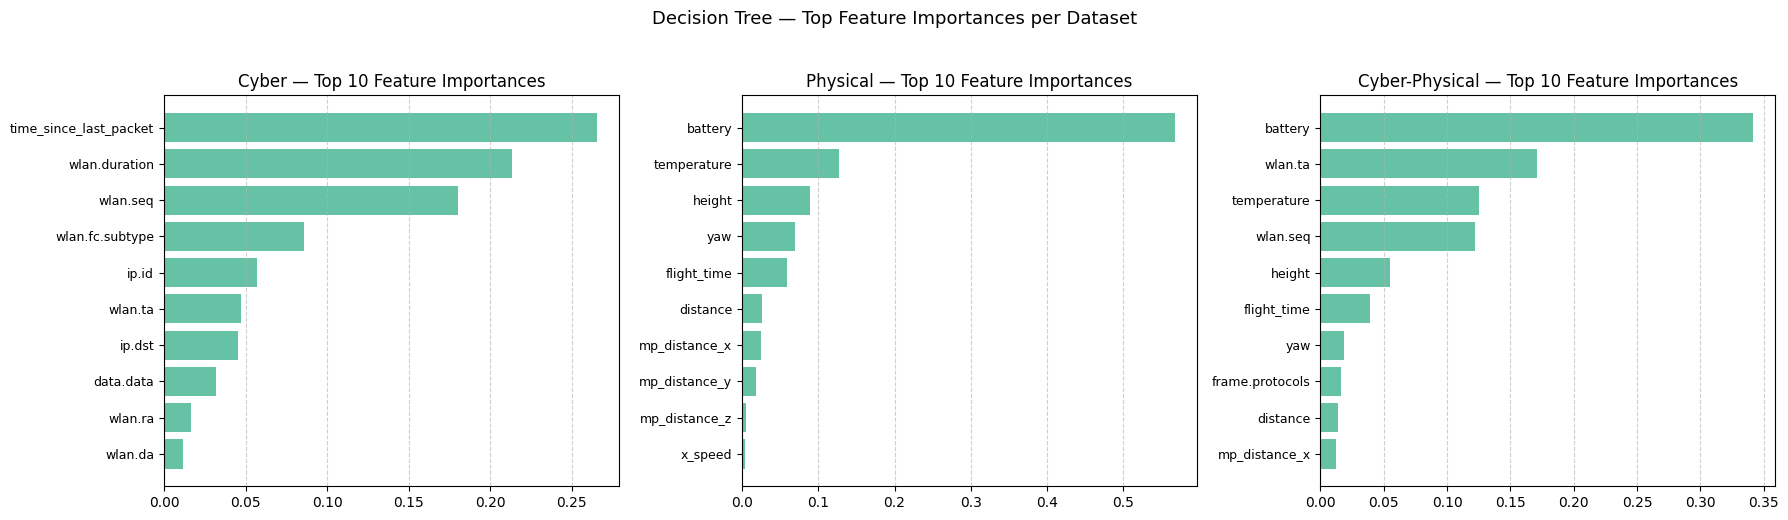

In [46]:
# === Simple Decision Tree Evaluation for 3 Datasets (Only Scaled Data) ===

results = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["CyberPhysical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Random Forest Classifier ---
    dt = DecisionTreeClassifier(criterion = 'entropy', random_state=42)

    # --- Training ---
    training_start = time.perf_counter()
    dt.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = dt.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_dt = (preds == y_test).sum().astype(float) / len(preds) * 100
    dt_train_time = training_end - training_start
    dt_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results[dataset] = {
        "accuracy": acc_dt,
        "train_time": dt_train_time,
        "pred_time": dt_prediction_time
    }

    # --- Feature Importances ---
    importances = dt.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF DECISION TREE RESULTS =====")
for ds, res in results.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("Decision Tree — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

## Random Forest 


===== SUMMARY OF RANDOM FOREST RESULTS =====
Cyber           | Accuracy: 71.52% | Train: 12.859s | Predict: 0.37874s
Physical        | Accuracy: 96.54% | Train: 1.491s | Predict: 0.05018s
Cyber_physical  | Accuracy: 97.31% | Train: 1.671s | Predict: 0.05105s


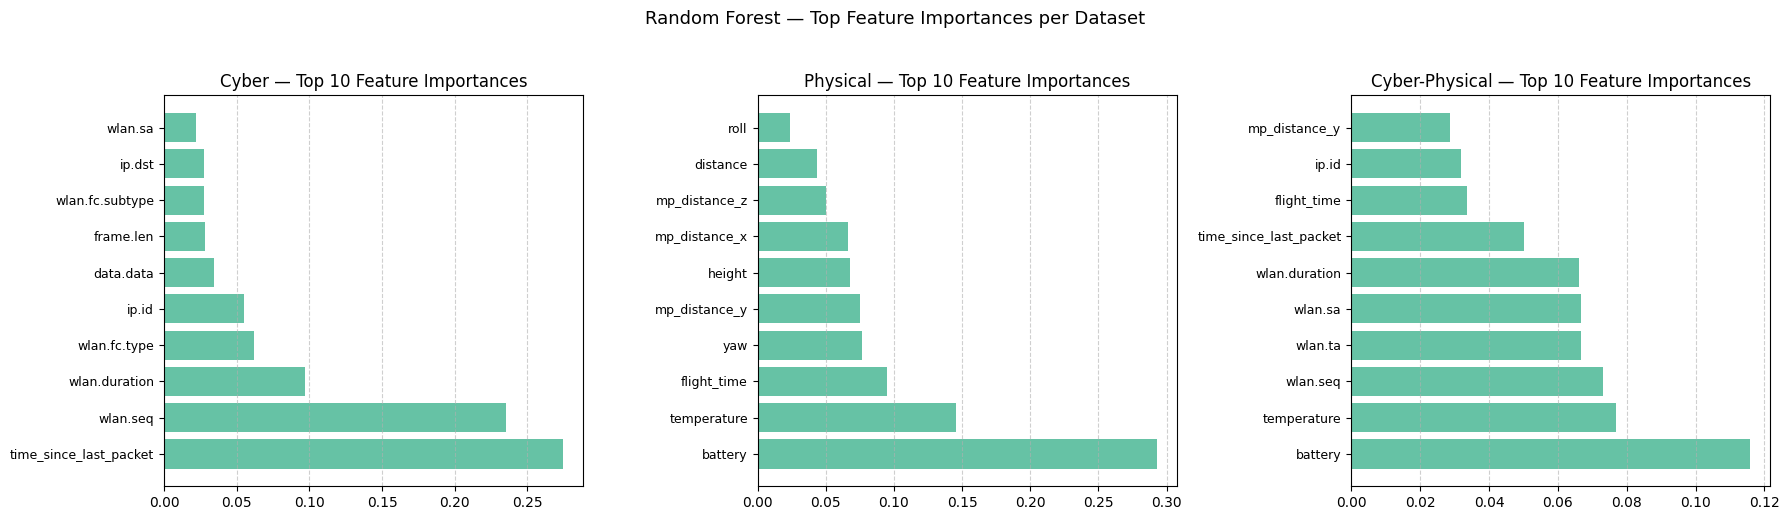

In [47]:
# === Simple Random Forest Evaluation for 3 Datasets (Only Scaled Data) ===

results = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["CyberPhysical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Random Forest Classifier ---
    rf = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)

    # --- Training ---
    training_start = time.perf_counter()
    rf.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = rf.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_rf = (preds == y_test).sum().astype(float) / len(preds) * 100
    rf_train_time = training_end - training_start
    rf_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results[dataset] = {
        "accuracy": acc_rf,
        "train_time": rf_train_time,
        "pred_time": rf_prediction_time
    }

    # --- Feature Importances ---
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF RANDOM FOREST RESULTS =====")
for ds, res in results.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("Random Forest — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()


The Random Forest results highlight clear differences in both performance and feature relevance across the three UAV datasets.
The **Cyber dataset** achieved an accuracy of **71.5%**, which, while decent, reflects the complexity of network traffic data. Features such as *time_since_last_packet* and *wlan.seq* dominate, showing their strong influence on attack detection.
The **Physical dataset** performed exceptionally well (**96.5% accuracy**), with *battery* and *temperature* emerging as the most critical variables. These features are strong indicators of abnormal UAV behavior under attack conditions.
The **Cyber-Physical dataset** reached the highest accuracy (**97.3%**), demonstrating the benefit of integrating both domains. Its top features combine physical (*battery*, *temperature*) and cyber (*wlan.seq*, *time_since_last_packet*) indicators, confirming that the hybrid dataset captures a more complete representation of system behavior, leading to superior classification performance.


## XGBoost


===== SUMMARY OF XGBoost RESULTS =====
Cyber           | Accuracy: 76.53% | Train: 2.486s | Predict: 0.03814s
Physical        | Accuracy: 98.52% | Train: 0.695s | Predict: 0.01467s
Cyber_physical  | Accuracy: 98.97% | Train: 0.844s | Predict: 0.00637s


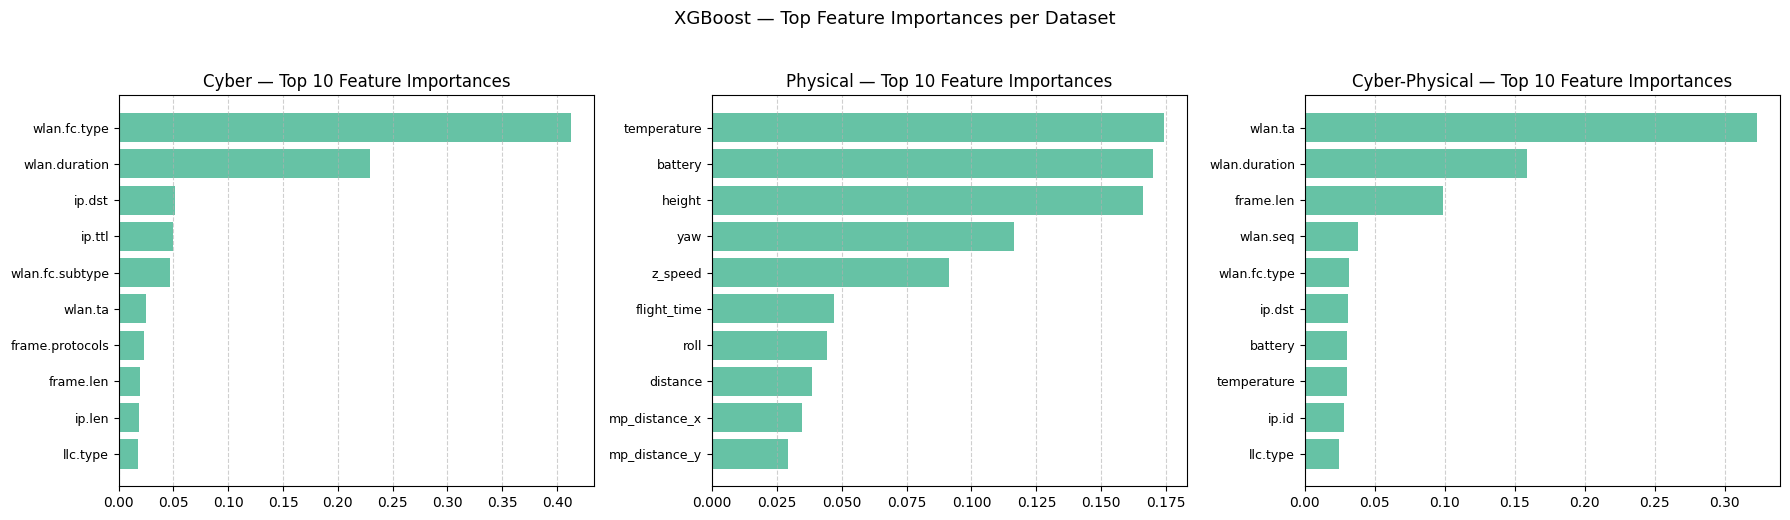

In [48]:
# === Simple XGBoost Evaluation for 3 Datasets (Only Scaled Data) ===

results = {}
feature_importances = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        X_scaled = X_cyber_scaled
        y = y_cyber
        feature_names = processed_data["Cyber"]["scaler"].feature_names_in_
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
        feature_names = processed_data["Physical"]["scaler"].feature_names_in_
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp
        feature_names = processed_data["CyberPhysical"]["scaler"].feature_names_in_

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- XGBoost Classifier ---
    xgb = XGBClassifier(n_estimators=100)

    # --- Training ---
    training_start = time.perf_counter()
    xgb.fit(X_train, y_train)
    training_end = time.perf_counter()

    # --- Prediction ---
    prediction_start = time.perf_counter()
    preds = xgb.predict(X_test)
    prediction_end = time.perf_counter()

    # --- Accuracy ---
    acc_xgb = (preds == y_test).sum().astype(float) / len(preds) * 100
    xgb_train_time = training_end - training_start
    xgb_prediction_time = prediction_end - prediction_start

    # --- Save results ---
    results[dataset] = {
        "accuracy": acc_xgb,
        "train_time": xgb_train_time,
        "pred_time": xgb_prediction_time
    }

    # --- Feature Importances ---
    importances = xgb.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_n = min(10, len(importances))  # top 10
    feature_importances[dataset] = (feature_names[indices[:top_n]], importances[indices[:top_n]])

# === Summary ===
print("\n===== SUMMARY OF XGBoost RESULTS =====")
for ds, res in results.items():
    print(f"{ds.capitalize():15s} | Accuracy: {res['accuracy']:.2f}% | "
          f"Train: {res['train_time']:.3f}s | Predict: {res['pred_time']:.5f}s")

# === Plot Feature Importances Side by Side ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    features, importances = feature_importances[ds]
    ax.barh(range(len(features)), importances[::-1], color="#66c2a5")
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels(features[::-1], fontsize=9)
    ax.set_title(f"{title} — Top 10 Feature Importances")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

fig.suptitle("XGBoost — Top Feature Importances per Dataset", fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

## Models Performance Recap

In [59]:
results = pd.DataFrame({
    'Model': ['SVM', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_svm, acc_dt, acc_rf, acc_xgb],
    'Runtime Training': [svm_train_time, dt_train_time, rf_train_time, xgb_train_time],
    'Runtime Prediction': [svm_prediction_time, dt_prediction_time, rf_prediction_time, xgb_prediction_time]})
result_df = results.sort_values(by='Accuracy', ascending=False)
result_df = result_df.set_index('Model')
print("\n===== MODELS PERFORMANCE RANKING - FOR CYBER-PHYSICAL DATASET =====")
display(result_df.style.format("{:.4f}"))


===== MODELS PERFORMANCE RANKING - FOR CYBER-PHYSICAL DATASET =====


,Accuracy,Runtime Training,Runtime Prediction
Model,,,
XGBoost,98.9737,0.8439,0.0064
Decision Tree,97.9474,0.0415,0.0005
Random Forest,97.3060,1.6714,0.0510
SVM,89.0314,0.6271,0.1315


# **Fine Tuning**

## Random Forest

In [50]:
# === Fine-Tuning Random Forest (Grid Search) for 3 Datasets with Random Sampling for Cyber ===

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

results = {}

for dataset in ["cyber", "physical", "cyber_physical"]:
    # --- Dataset configuration ---
    if dataset == "cyber":
        # Randomly sample 1/5 of the dataset
        X_temp, _, y_temp, _ = train_test_split(
            X_cyber_scaled, y_cyber, test_size=0.8, random_state=42, stratify=y_cyber
        )
        X_scaled = X_temp
        y = y_temp
    elif dataset == "physical":
        X_scaled = X_physical_scaled
        y = y_physical
    else:  # cyber_physical
        X_scaled = X_cp_scaled
        y = y_cp

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.25, random_state=42, stratify=y
    )

    # --- Grid Search ---
    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=1
    )

    grid_start = time.perf_counter()
    grid.fit(X_train, y_train)
    grid_end = time.perf_counter()
    grid_duration = grid_end - grid_start

    # --- Best results ---
    best_params = grid.best_params_
    best_score = grid.best_score_
    best_rf = grid.best_estimator_

    # --- Evaluation on Test Set ---
    y_pred = best_rf.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    results[dataset] = {
        "best_params": best_params,
        "cv_acc": best_score,
        "test_acc": acc_test,
        "duration": grid_duration,
        "best_model": best_rf,
        "y_test": y_test,
        "y_pred": y_pred
    }

# === Summary ===
print("\n===== SUMMARY OF RANDOM FOREST GRID SEARCH RESULTS =====")
for ds, res in results.items():
    print(f"{ds.capitalize():15s} | Test Acc: {res['test_acc']:.4f} | "
          f"CV Acc: {res['cv_acc']:.4f} | Duration: {res['duration']:.2f}s")
    print(f"Best params: {res['best_params']}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Fitting 3 folds for each of 216 candidates, totalling 648 fits

===== SUMMARY OF RANDOM FOREST GRID SEARCH RESULTS =====
Cyber           | Test Acc: 0.6991 | CV Acc: 0.6995 | Duration: 78.38s
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Physical        | Test Acc: 0.9615 | CV Acc: 0.9444 | Duration: 67.47s
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Cyber_physical  | Test Acc: 0.9724 | CV Acc: 0.9553 | Duration: 80.47s
Best params: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


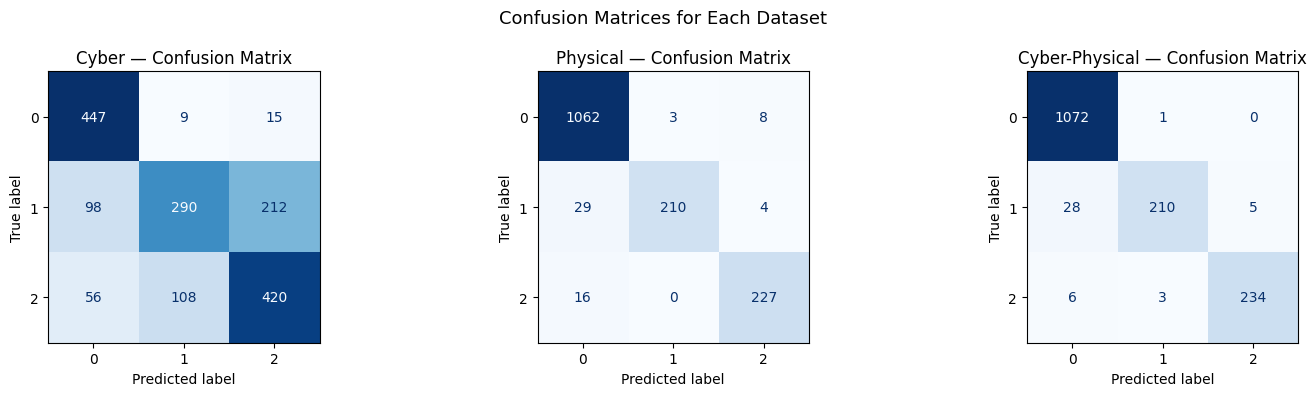


===== PERFORMANCE SUMMARY =====


,Accuracy,Recall,F1-Score
Dataset,,,
Cyber,0.6991,0.6991,0.6869
Physical,0.9615,0.9615,0.9610
Cyber-Physical,0.9724,0.9724,0.9718


In [ ]:
metrics_summary = []
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets_order = ["cyber", "physical", "cyber_physical"]
titles = ["Cyber", "Physical", "Cyber-Physical"]

for ax, ds, title in zip(axes, datasets_order, titles):
    y_test = results[ds]["y_test"]
    y_pred = results[ds]["y_pred"]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    metrics_summary.append({
        "Dataset": title,
        "Accuracy": acc,
        "Recall": rec,
        "F1-Score": f1
    })

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{title} — Confusion Matrix")

plt.suptitle("Confusion Matrices for Each Dataset", fontsize=13)
plt.tight_layout()
plt.show()

# Summary table
df_metrics = pd.DataFrame(metrics_summary)
df_metrics.set_index("Dataset", inplace=True)
print("\n===== PERFORMANCE SUMMARY =====")
display(df_metrics.style.format("{:.4f}").set_caption("Performance Metrics per Dataset"))


The fine-tuned Random Forest through Grid Search significantly improved model performance across datasets. After optimizing key parameters such as tree depth, number of estimators, and split criteria, the **Cyber dataset** achieved **69.9% accuracy**, showing moderate results due to complex and overlapping network patterns. The **Physical dataset** reached **96.1%**, and the **Cyber-Physical dataset** performed best with **97.2% accuracy**, confirming that fine-tuning enhanced the model’s ability to capture relevant relationships. Overall, the fine-tuned Random Forest demonstrates strong detection capability, especially when trained on integrated cyber-physical data.


## XGBoost

# **Summary**

# partie Colin

Méthode XGBoost 

Scores: [1.         0.99839615 0.99919808 0.99839615 1.        ]
Mean: 0.9991980753809141
Standard Deviation: 0.0007172631844425825


<Axes: xlabel='Feature'>

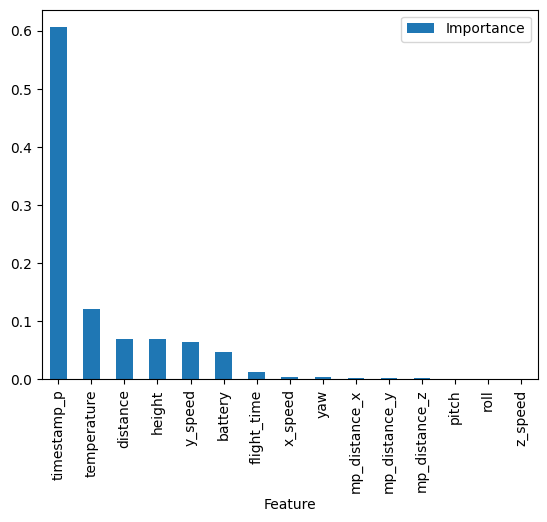

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

xgb = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb, X, y_encoded, cv=kf5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


X.drop(columns=['barometer'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 2. Découpage train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
xgb.fit(X_train, y_train)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

importances.plot.bar()